### Introdução

Os dados utilizados neste projeto foram extraídos do site [Investing.com](https://br.investing.com/indices/bovespa-historical-data), correspondendo a série histórica do Ibovespa, principal índice da bolsa de valores brasileira (B3). Esse índice mostra o desempenho médio das ações mais negociadas do mercado e é utilizado como referência para análises financeiras e indicadores econômicos.

O conjunto de dados apresenta as seguintes informações:

- Data;
- Último (preço de fechamento);
- Abertura;
- Máxima;
- Mínima;
- Volume;
- Variação (%).

A partir destes dados, é póssível realizar uma análise exploratória, identificar tendências de mercado e avaliar variações ao longo do tempo.

#### Entendendo o DataFrame

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive, AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np
from statsforecast.models import ARIMA
from prophet import Prophet

In [41]:
df = pd.read_csv("dados_ibovespa.csv")

#Verificando 5 primeiras linhas do Dataframe
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
1,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
2,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
3,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
4,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"


In [42]:
#Verificando valores nulos

df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [43]:
# Verificando Dtype

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4953 non-null   object 
 1   Último    4953 non-null   float64
 2   Abertura  4953 non-null   float64
 3   Máxima    4953 non-null   float64
 4   Mínima    4953 non-null   float64
 5   Vol.      4952 non-null   object 
 6   Var%      4953 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.0+ KB


Utilizamos o "dados.info()" para verificar os tipos de dados que temos na base. 
Verificamos que a coluna "Data" está como "object", então fizemos a conversão dela para o tipo "datetime" e depois definimos essa coluna como índice do DataFrame ordenando os dados em sequência cronológica.

In [44]:
#Convertendo a coluna "Data" em datetime
df["Data"] = pd.to_datetime(df["Data"], format = '%d.%m.%Y', errors='coerce')

#Definindo a coluna "Data" como índece e ordenando-a
df = df.set_index('Data').sort_index()

# Reindexando para ter uma linha por dia, preenchendo valores ausentes com o último valor disponível
df = df.asfreq('D', method='ffill')

# Preenchendo valores ausentes nas outras colunas com o último valor
for column in df.columns:
    df[column] = df[column].fillna(method='ffill')

# Resetar o índice
df.reset_index(inplace=True)


C:\Users\maria\AppData\Local\Temp\ipykernel_2680\3330368162.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column] = df[column].fillna(method='ffill')


In [45]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%"
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%"
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%"
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%"
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%"


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7304 entries, 0 to 7303
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      7304 non-null   datetime64[ns]
 1   Último    7304 non-null   float64       
 2   Abertura  7304 non-null   float64       
 3   Máxima    7304 non-null   float64       
 4   Mínima    7304 non-null   float64       
 5   Vol.      7304 non-null   object        
 6   Var%      7304 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 399.6+ KB


In [47]:
# Add coluna categórica
df['unique_id'] = 'ibovespa'

In [48]:
#Renomeando colunas 
df = df.rename(columns={'Data': 'ds', 'Último': 'y'})

#Mantendo apenas as colunas necessárias para análise
df_a = df[['ds', 'y', 'unique_id']]

df_a.head()

,ds,y,unique_id
0,2005-07-11,25.016,ibovespa
1,2005-07-12,25.536,ibovespa
2,2005-07-13,25.856,ibovespa
3,2005-07-14,25.920,ibovespa
4,2005-07-15,25.222,ibovespa


A ideia aqui foi definir uma nova coluna (unique_id) e manter no dataframe apenas as colunas importantes para a análise

In [49]:
#Separando df para o Prophet
df_p = df
df_p.head()

,ds,y,Abertura,Máxima,Mínima,Vol.,Var%,unique_id
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",ibovespa
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",ibovespa
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",ibovespa
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",ibovespa
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",ibovespa


### Análise Inicial

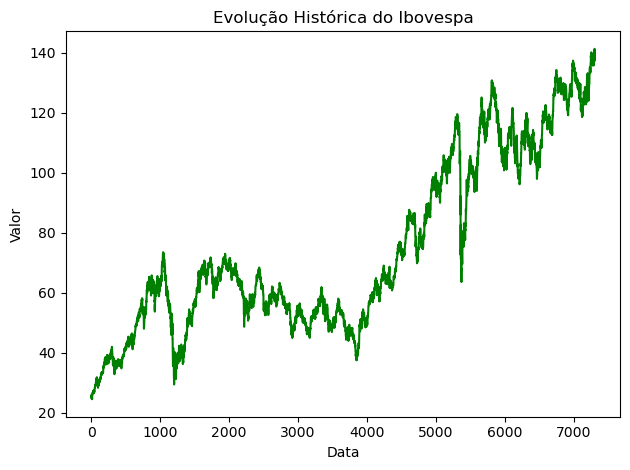

In [50]:
plt.plot(df.index, df["y"], color='green')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Evolução Histórica do Ibovespa')
plt.show()

O gráfico acima apresenta a evolução diária do índice Ibovespa ao longo dos últimos anos, permitindo observar seu comportamento e identificar possíveis padrões sazonais.

#### Decomposição da Série Temporal

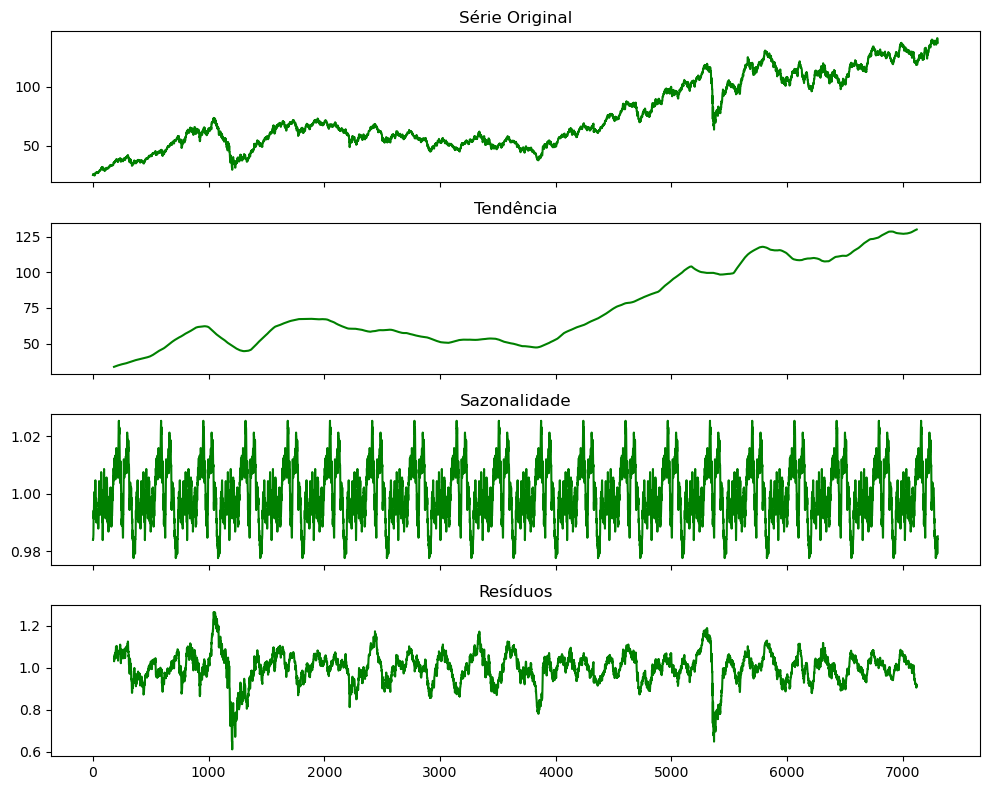

In [51]:
result = seasonal_decompose(df["y"], model="multiplicative", period=365)
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axs[0].plot(result.observed, color='green')
axs[0].set_title('Série Original')

axs[1].plot(result.trend, color='green')
axs[1].set_title('Tendência')

axs[2].plot(result.seasonal, color='green')
axs[2].set_title('Sazonalidade')

axs[3].plot(result.resid, color='green')
axs[3].set_title('Resíduos')

plt.tight_layout()
plt.show()

A série tem uma tendência de crescimento ao longo do tempo. Os picos e vales também aumentam junto com o valor geral da série. Como o comportamento sazonal cresce proporcionalmente ao valor da série, o modelo multiplicativo consegue representar melhor, onde a sazonalidade escala junto com a tendência.

#### Verificação de Estacionaridade

In [52]:
X = df.y.values

result = adfuller(X)
print('Teste ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print(f'   {key}: {value}')

     

Teste ADF: -1.124619
p-value: 0.705155
Valores Críticos:
   1%: -3.4312475857208686
   5%: -2.861936663242156
   10%: -2.566981139603197


O teste ADF verifica se uma série temporal é estacionária, ou seja, se suas propriedades estatísticas (como média e variância) não mudam ao longo do tempo. Com base nos valores da verificação, a série não é estacionária.

--------------
- ADF Statistic:	Valor do teste, quanto mais negativo, maior a chance da série ser estacionária.
- p-value:	Se for menor que 0.05, geralmente consideramos a série estacionária.
- Critical Values:	Valores de referência (níveis de significância de 1%, 5% e 10%) para comparar com o ADF Statistic. Se o ADF for menor que esse valor, a série é estacionária com aquele grau de confiança.
---------------

#### Aplicando Diferenciação

In [53]:
from statsmodels.tsa.stattools import adfuller

In [54]:
df['y_diff'] = df['y'].diff().dropna()
result = adfuller(df['y_diff'].dropna())
print('Teste ADF:', result[0])
print('p-value:', result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'  {key}: {value}') 


Teste ADF: -20.28598549242787
p-value: 0.0
Valores Críticos:
  1%: -3.4312475857208686
  5%: -2.861936663242156
  10%: -2.566981139603197


Com o ADF Teste: -20.2858 e p-value: 0.0 (muito menor que 0.05). Concluímos que após a primeira diferenciação, a série se tornou estacionária.



##### Plotar ACF e PACF para estimar p e q

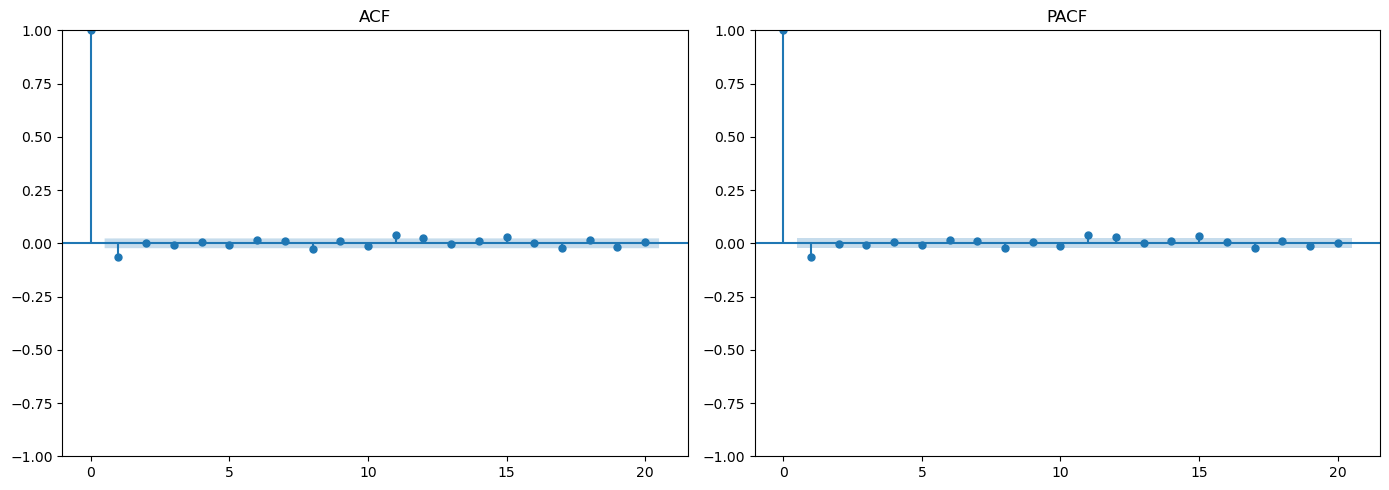

In [55]:
plt.rcParams.update({'figure.autolayout': True}) 

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df['y_diff'].dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF')

plot_pacf(df['y_diff'].dropna(), lags=20, ax=axes[1], method='ywm') 
axes[1].set_title('PACF')

plt.show()



O gráfico de ACF apresenta um pico significativo no lag 1, enquanto os demais lags estão dentro da zona de confiança. Isso indica que existe uma dependência de curto prazo na série, sendo recomendada a inclusão de 1 componente de média móvel (q = 1) no modelo.
O gráfico de PACF também mostra um pico no lag 1, com os demais lags rapidamente se aproximando de zero e permanecendo dentro da zona de confiança. Esse comportamento sugere a presença de 1 componente autoregressivo (p = 1).

#### Análise de Tendência

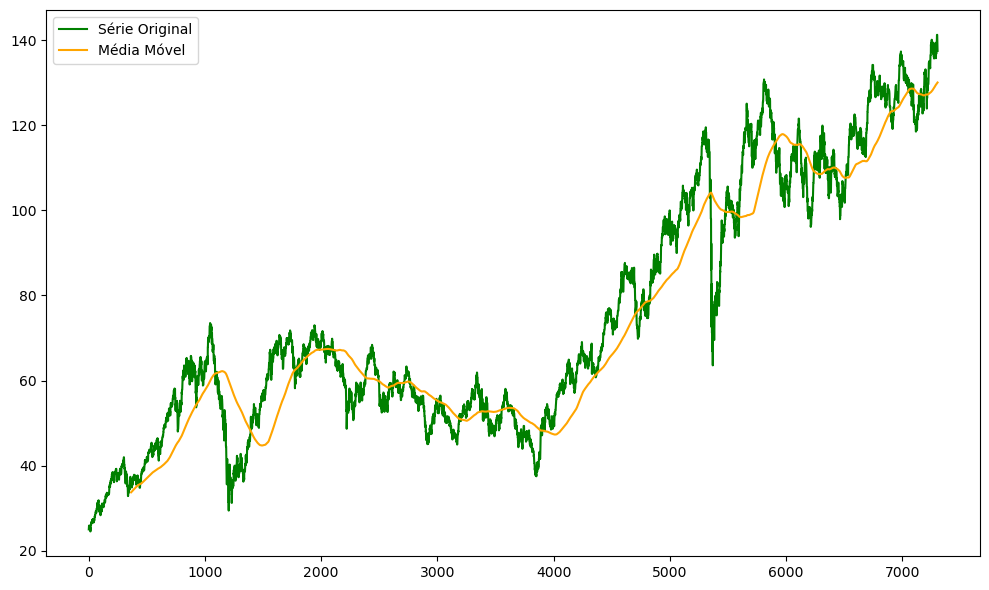

In [56]:
# Calcular média móvel com janela menor
ma = df['y'].rolling(window=365).mean()

# Criar o gráfico
f, ax = plt.subplots(figsize=(10,6))
df['y'].plot(ax=ax, label='Série Original', color='green')
ma.plot(ax=ax, label='Média Móvel', color='orange')
plt.legend()
plt.tight_layout()

Nesta análise, calculamos a média móvel utilizando uma janela de 365 dias para observar o comportamento dos dados ao longo do tempo. Através dessa média, podemos identificar uma tendência de crescimento nos dados.

Além da tendência de alta, é possível observar três quedas acentuadas na série histórica:

- 2008: Queda provocada pela crise financeira global, desencadeada pela falência do Lehman Brothers e o colapso do mercado imobiliário nos Estados Unidos.
- 2016: Redução associada à crise política e econômica no Brasil, marcada pela recessão e pelo processo de impeachment da presidente Dilma Rousseff.
- 2020: Forte recuo devido à pandemia de COVID-19, que gerou incertezas nos mercados globais e queda na bolsa de valore.

Esses eventos destacam como fatores externos e internos podem impactar significativamente o desempenho do mercado, mesmo em períodos de tendência de crescimento.

#### Métricas de Avaliação do Modelo

In [57]:
# Funções de Avaliação

def wmape(y_true, y_pred):
   return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

def calculate_smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")
     

#### Preparação do Modelo

In [58]:
# Filtrar base de treino entre Jan 2020 até Dez de 2023
train = df_a.loc[df_a['ds'] < '2025-06-09']

# Filtrar base de teste entre Jan 2024 até Jun de 2024
valid = df_a.loc[(df_a['ds'] >= '2025-06-09') & (df_a['ds'] < '2025-07-09')]

h = valid['ds'].nunique()

In [59]:
h

30

### Modelo Naive

In [60]:
model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model.fit(train)

forecast_df = model.predict(h=h, level=[80])
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_df = forecast_df[['ds', 'unique_id', 'Naive', 'Naive-lo-80', 'Naive-hi-80', 'y']]
forecast_df = forecast_df.set_index('ds') 
forecast_df = forecast_df.dropna()
forecast_df.head()

,unique_id,Naive,Naive-lo-80,Naive-hi-80,y
ds,,,,,
2025-06-09,ibovespa,136.102,134.894482,137.309518,135.699
2025-06-10,ibovespa,136.102,134.394311,137.809689,136.436
2025-06-11,ibovespa,136.102,134.010517,138.193483,137.128
2025-06-12,ibovespa,136.102,133.686963,138.517037,137.800
2025-06-13,ibovespa,136.102,133.401907,138.802093,137.213


WMAPE: 1.50%


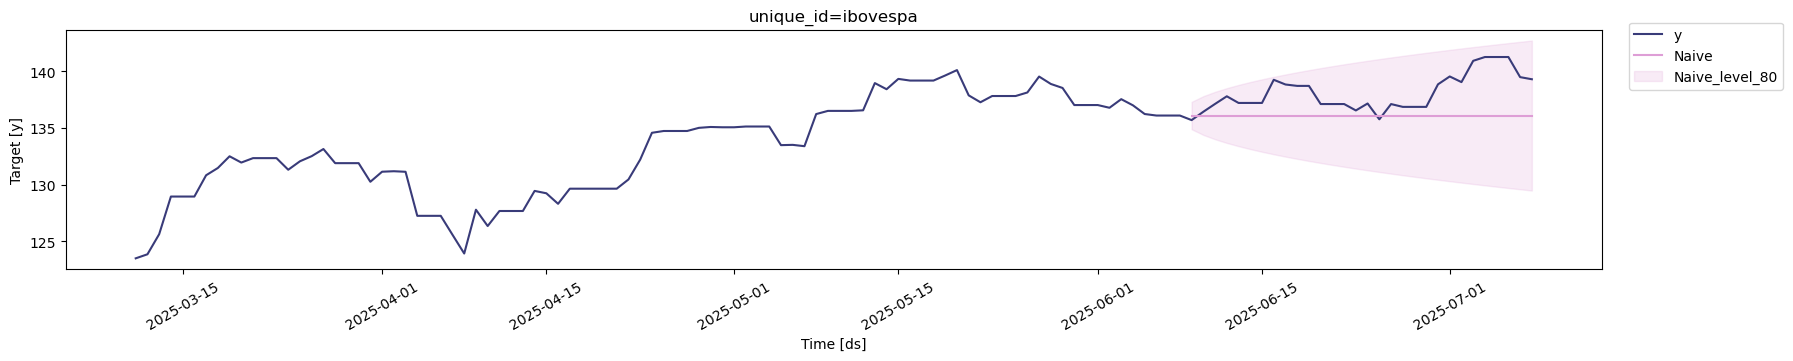

In [61]:

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")
model.plot(train, forecast_df.reset_index(), level=[80], engine='matplotlib', max_insample_length=90)

In [62]:
# Calculando MAE e RMSE
mae = mean_absolute_error(forecast_df['y'], forecast_df['Naive'])
rmse = root_mean_squared_error(forecast_df['y'], forecast_df['Naive'])

# Exibindo tudo
print(f"WMAPE: {wmape1:.2%}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

WMAPE: 1.50%
MAE: 2.0720
RMSE: 2.5784


### Modelo Arima

In [63]:
print(train.columns)
train = train[['unique_id', 'ds', 'y']].copy()

Index(['ds', 'y', 'unique_id'], dtype='object')


In [64]:
# Defina os parâmetros do ARIMA (exemplo: p=1, d=1, q=1)
model_a = StatsForecast(models=[ARIMA(order=(1, 1, 1))], freq='D', n_jobs=-1)

# Ajusta o modelo
model_a.fit(train)

# Faz a previsão
forecast_dfa = model_a.predict(h=h, level=[80])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')
forecast_dfa = forecast_dfa.drop(columns='index', errors='ignore')

# Remove valores ausentes
forecast_dfa = forecast_dfa.dropna(subset=['y', 'ARIMA'])
forecast_dfa = forecast_dfa.drop(columns=['y_diff-lo-80', 'y_diff'], errors='ignore')



WMAPE: 1.50%


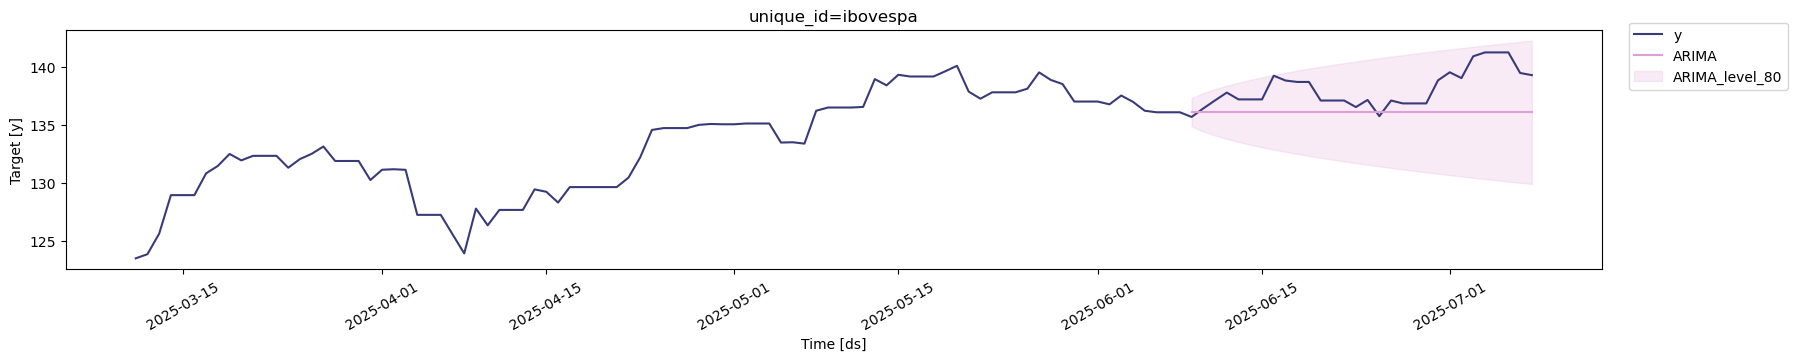

In [65]:
# Define função WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Verifica se a soma dos valores reais é zero
if np.sum(forecast_dfa['y'].values) == 0:
    print("A soma dos valores reais é zero, o que causa divisão por zero no cálculo do WMAPE.")
else:
    wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['ARIMA'].values)
    print(f"WMAPE: {wmape4:.2%}")

# Plota o resultado
model_a.plot(train, forecast_dfa, level=[80], engine='matplotlib', max_insample_length=90)


In [66]:

# Calculando outras métricas
mae = mean_absolute_error(forecast_dfa['y'], forecast_dfa['ARIMA'])
rmse = root_mean_squared_error(forecast_dfa['y'], forecast_dfa['ARIMA'])

# Exibindo tudo
print(f"WMAPE: {wmape4:.2%}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

WMAPE: 1.50%
MAE: 2.0718
RMSE: 2.5783


O modelo ARIMA(1, 1, 1) foi ajustado aos dados da série temporal com frequência diária e apresentou um bom desempenho preditivo. A avaliação do modelo foi realizada com base no WMAPE (Weighted Mean Absolute Percentage Error), que resultou em 1,50%, indicando que o erro médio das previsões em relação aos valores reais é bastante baixo.

Além disso, o gráfico de previsão mostra que o modelo conseguiu capturar bem o comportamento da série, com a linha de previsão (em rosa) acompanhando adequadamente a linha dos valores reais (em azul escuro). A área sombreada representa o intervalo de confiança de 80%, sinalizando a incerteza das previsões, e mostra-se relativamente estreita, o que reforça a estabilidade e confiança do modelo.

### Modelo AutoArima

In [67]:
print(forecast_dfa.columns)

Index(['unique_id', 'ds', 'ARIMA', 'ARIMA-lo-80', 'ARIMA-hi-80', 'y'], dtype='object')


WMAPE: 1.34%


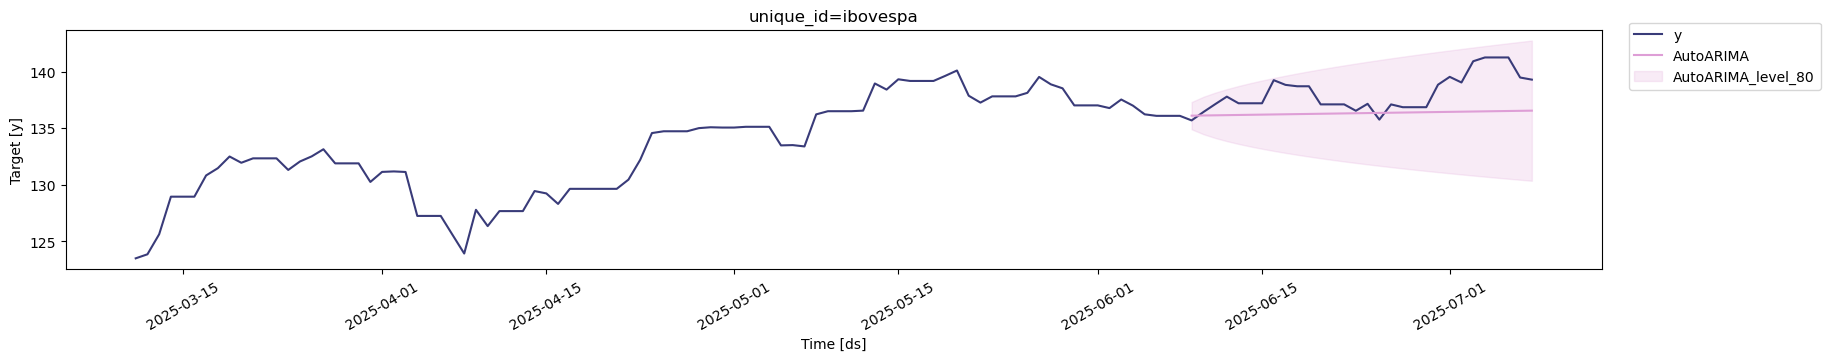

In [68]:
# Ajustando o modelo
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(train)

# Fazendo a previsão
forecast_dfa = model_a.predict(h=h, level=[80])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Removendo valores ausentes
forecast_dfa = forecast_dfa.dropna(subset=['y', 'AutoARIMA'])

# Calculando WMAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# Verificando se a soma dos valores reais é zero
if np.sum(forecast_dfa['y'].values) == 0:
    print("A soma dos valores reais é zero, o que causa divisão por zero no cálculo do WMAPE.")
else:
    wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
    print(f"WMAPE: {wmape4:.2%}")

# Plotando o resultado
forecast_dfa = forecast_dfa.set_index('index')
model_a.plot(train, forecast_dfa, level=[80], engine='matplotlib', max_insample_length=90)
     

In [69]:
# Calculando MAE e RMSE
mae = mean_absolute_error(forecast_dfa['y'], forecast_dfa['AutoARIMA'])
rmse = root_mean_squared_error(forecast_dfa['y'], forecast_dfa['AutoARIMA'])

# Exibindo todas as métricas
print(f"WMAPE: {wmape4:.2%}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

WMAPE: 1.34%
MAE: 1.8526
RMSE: 2.3443


## Conclusão

- Modelo Naive: Funcionou razoavelmente bem com WMAPE de 1.50% e MAE de 2.0720. Desempenho bom para um baseline, mas limitado para séries com movimento mais complexo.
- Modelo ARIMA(1,1,1): Obteve o mesmo desempenho do Naive com WMAPE 1.50% e MAE 2.0718. Não trouxe ganho real comparado ao Modelo Naive.
- Modelo AutoARIMA: Melhor desempenho entre os três modelos com WMAPE: 1.34%, MAE: 1.8526 e RMSE: 2.3443. Mostra que conseguiu aprender melhor a estrutura da série e prever com mais precisão. A vantagem dele é que ele é adaptável evita tentativa e erro na escolha dos hiperparâmetros, ela testa várias combinações dos parâmetros do ARIMA (p, d, q) e seleciona a melhor.

### Modelo Prophet

In [70]:
df_p.head()

,ds,y,Abertura,Máxima,Mínima,Vol.,Var%,unique_id,y_diff
0,2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",ibovespa,NaN
1,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",ibovespa,0.520
2,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",ibovespa,0.320
3,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",ibovespa,0.064
4,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",ibovespa,-0.698


In [71]:
df_p = df_p[["ds", "y", "Abertura"]]
df_p.head()

,ds,y,Abertura
0,2005-07-11,25.016,24.425
1,2005-07-12,25.536,25.027
2,2005-07-13,25.856,25.557
3,2005-07-14,25.920,25.859
4,2005-07-15,25.222,25.916


In [72]:
df_p = df_p.rename(columns={'Abertura':'Open'})
df_p.head()

,ds,y,Open
0,2005-07-11,25.016,24.425
1,2005-07-12,25.536,25.027
2,2005-07-13,25.856,25.557
3,2005-07-14,25.920,25.859
4,2005-07-15,25.222,25.916


In [73]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7304 entries, 0 to 7303
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      7304 non-null   datetime64[ns]
 1   y       7304 non-null   float64       
 2   Open    7304 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 171.3 KB


In [74]:
# Filtrar base de treino entre Jan 2020 até Dez de 2023
train_prophet = df_p.loc[df_p['ds'] < '2025-06-09']

# Filtrar base de teste entre Jan 2024 até Jun de 2024
test_prophet = df_p.loc[(df_p['ds'] >= '2025-06-09') & (df_p['ds'] < '2025-07-09')]
     

In [75]:
model_p = Prophet(daily_seasonality=True)
model_p.fit(train_prophet)

future = model_p.make_future_dataframe(periods=len(test_prophet))
future["Open"] = pd.concat([train_prophet["Open"], test_prophet["Open"]], ignore_index=True)
forecast_p = model_p.predict(future)

preds = forecast_p[["ds", "yhat"]].tail(len(test_prophet))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
19:28:52 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Users\maria\anaconda3\Lib\site-packages\prophet\stan_model\prophet_model.bin random seed=93615 data file=C:\Users\maria\AppData\Local\Temp\tmpuhrfatvo\7l1tnjg1.json init=C:\Users\maria\AppData\Local\Temp\tmpuhrfatvo\8p6v6eoa.json output file=C:\Users\maria\AppData\Local\Temp\tmpuhrfatvo\prophet_model4vxyixne\prophet_model-20250722192852.csv method=optimize algorithm=newton iter=10000' failed: 